### Data Prep

Loading the token-wise surprisals, aligning them with the word-level RTs, and computing predictors. Length & log frequency are control predictors, and we also add the previous token's surprisal, length, and frequency to control for spill-over effects. Exclude OOV items and items before/after punctuation/non-alphabetical tokens.

In [1]:
import pandas as pd
from src.tokenization_analysis import *

In [2]:
rts = pd.read_csv("dundee_rts_v1.csv")
rts["token"] = rts["token"].str.replace('[^\w\s]','')
rts['token'].replace('', np.nan, inplace=True)
rts = rts.dropna()
baseline = pd.read_csv("surprisal_data/v1/baseline.csv")
bpe = pd.read_csv("surprisal_data/v1/bpe.csv")

/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [3]:
baseline_rts = combine_data(rts, baseline)
baseline_rts = generate_predictors(baseline_rts)
baseline_rts = baseline_rts[(~baseline_rts['oov']) & (~baseline_rts['exclude_rt'])]

In [4]:
bpe_rts = combine_data(rts, bpe, word_boundary = 'Ġ')
bpe_rts = generate_predictors(bpe_rts)
bpe_rts = bpe_rts[(~bpe_rts['oov']) & (~bpe_rts['exclude_rt'])]

In [5]:
bpe_rts

,token,transcript_id,sentence_id,surprisal,oov,rt,token_uid,exclude_rt,word_length,log_freq,word,prev_freq,prev_len,prev_surprisal
1,renaissance,13,0,14.074871,False,396.400000,1,0,11,-4.735928,renaissance,-2.218148,3.0,4.532436
2,in,13,0,5.865422,False,163.250000,2,0,2,-2.043987,in,-4.735928,11.0,14.074871
5,is,13,0,4.915674,False,185.000000,5,0,2,-2.223688,is,-4.142604,10.0,16.665718
6,turning,13,0,11.586292,False,326.777778,6,0,7,-4.133627,turning,-2.223688,2.0,4.915674
7,out,13,0,2.945987,False,186.800000,7,0,3,-2.792071,out,-4.133627,7.0,11.586292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,architectural,16,107,17.207958,False,360.166667,51493,0,13,-4.773027,architectural,-4.088652,6.0,12.387107
51226,the,16,107,2.257757,False,708.000000,51496,0,3,-2.218148,the,-5.416809,7.0,21.874280
51227,slick,16,107,15.827176,False,292.666667,51497,0,5,-4.786134,slick,-2.218148,3.0,2.257757
51228,with,16,107,5.806637,False,189.428571,51498,0,4,-2.335966,with,-4.786134,5.0,15.827176


In [6]:
baseline_rts

,token,transcript_id,sentence_id,surprisal,oov,rt,token_uid,exclude_rt,word_length,log_freq,word,prev_freq,prev_len,prev_surprisal
1,renaissance,13,0,13.994410,False,396.400000,1,0,11,-4.735928,renaissance,-2.218148,3.0,4.531791
2,in,13,0,5.909969,False,163.250000,2,0,2,-2.043987,in,-4.735928,11.0,13.994410
5,is,13,0,4.846577,False,185.000000,5,0,2,-2.223688,is,-4.142604,10.0,14.905993
6,turning,13,0,11.551354,False,326.777778,6,0,7,-4.133627,turning,-2.223688,2.0,4.846577
7,out,13,0,2.951636,False,186.800000,7,0,3,-2.792071,out,-4.133627,7.0,11.551354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,architectural,16,107,17.199008,False,360.166667,51493,0,13,-4.773027,architectural,-4.088652,6.0,12.466434
51226,the,16,107,2.560108,False,708.000000,51496,0,3,-2.218148,the,-5.416809,7.0,19.933248
51227,slick,16,107,16.012193,False,292.666667,51497,0,5,-4.786134,slick,-2.218148,3.0,2.560108
51228,with,16,107,5.929988,False,189.428571,51498,0,4,-2.335966,with,-4.786134,5.0,16.012193


After excluding OOV items, the baseline dataset has many more tokens. This should make sure we are looking at the same experimental datapoints for each model.

In [7]:
baseline_rts = baseline_rts[baseline_rts['token_uid'].isin(bpe_rts['token_uid'])]

Making sure the same tokens are in each dataframe

In [8]:
sum(baseline_rts['token_uid'].values == bpe_rts['token_uid'].values) == len(baseline_rts.index)

True

### Exploring differences in surprisal distributions

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'Surprisal')

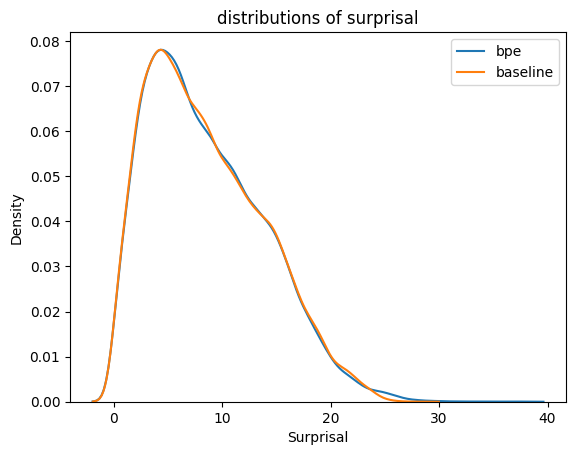

In [11]:
sns.kdeplot(bpe_rts['surprisal'], label = 'bpe')
sns.kdeplot(baseline_rts['surprisal'], label = 'baseline')
plt.title("distributions of surprisal")
plt.legend()
plt.xlabel("Surprisal")

The `entropy` function in Scipy computes KL-divergence between distributions

In [12]:
from scipy.stats import entropy

In [14]:
entropy(bpe_rts['surprisal'], baseline_rts['surprisal'])

0.0019146557068106564

### Regression

In [15]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
stats = importr('stats')
base = importr('base')
pandas2ri.activate()

R = robjects.r

For each tokenization scheme, we fit a control model predicting reading time with the length and frequency predictors, and then a model incorporating the surprisal

Fitting the baseline models

In [16]:
control_formula = 'rt ~ log_freq * word_length + prev_freq * prev_len'
control_baseline_model = R.lm(control_formula, data=baseline_rts)

In [17]:
surprisal_baseline_formula = 'rt ~ surprisal + prev_surprisal + log_freq * word_length + prev_freq * prev_len'
surprisal_baseline_model = R.lm(surprisal_baseline_formula, data=baseline_rts)

Coefficients for the current and previous tokens' surprisal

In [18]:
surprisal_baseline_model.rx2('coefficients')[1:3]

array([2.31867732, 2.14175588])

In [19]:
surprisal_baseline_model.rx2('coefficients')[0]

226.4360619004493

$\Delta LogLik$ for the baseline model 

In [20]:
R.logLik(surprisal_baseline_model) - R.logLik(control_baseline_model)

array([374.4858224])

Fitting the models for the BPE-tokenized data

In [21]:
control_bpe_model = R.lm(control_formula, data=bpe_rts)
surprisal_bpe_model = R.lm(surprisal_baseline_formula, data=bpe_rts)

$\Delta LogLik$ for the baseline model 

In [22]:
R.logLik(surprisal_bpe_model) - R.logLik(control_bpe_model)

array([389.07798])

Coefficients for the current and previous tokens' surprisal

In [23]:
surprisal_bpe_model.rx2('coefficients')[1:3]

array([2.41482646, 2.06836694])

The predictors look consistent with those of Goodkind & Bicknell(2018). Although there looked like there were major differences in the $\Delta LogLik$, their training corpora were larger. They also used a GAM instead of linear regression. Wilcox et al (2020) computed $\Delta LogLik$ per token under linear regression models. Our values here are consistent with their reported values for 5-gram models trained on the medium and large BLLIP corpora(0.01 - 0.015). They, however, reported averaged values for models with 10-fold cross validation. This would be the right thing to do for the final analysis.

In [24]:
(R.logLik(surprisal_baseline_model) - R.logLik(control_baseline_model)) / len(bpe_rts.index)

array([0.01032267])

In [25]:
(R.logLik(surprisal_bpe_model) - R.logLik(control_bpe_model)) / len(bpe_rts.index)

array([0.0107249])

This tells us that surprisal under a BPE-tokenized model was a slightly better predictor of RT data than the baseline model. Next steps would be to see if a model with a morphologically-informed tokenizer does better.